In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mato-katkovcin (nsiete-hrnciar-katkovcin). Use `wandb login --relogin` to force relogin


True

In [2]:
name_of_run = 'wider-conv-layers-8-image-generator-penalization-50epoch-stride(2,2)'

In [3]:
run = wandb.init(project="convolutional-nn", id=name_of_run)

In [4]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')
START_LR = config['default'].getfloat('start_lr')
MAX_LR = config['default'].getfloat('max_lr')
STEPS_PER_EPOCH = config['default'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['default']['strategy']

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})

In [5]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


<AxesSubplot:title={'center':'Animal class distribution'}, ylabel='Animal'>

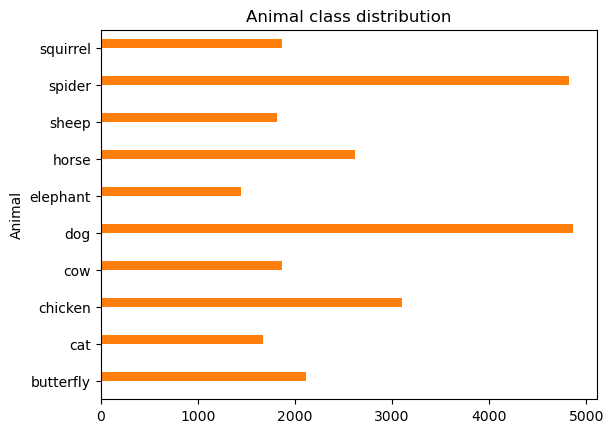

In [6]:
distribution = dict(zip(class_names, class_sizes))
distributionDf = pd.DataFrame.from_dict(distribution.items())
distributionDf.columns = ['Animal', 'Count']
distributionDf = distributionDf.reset_index()

distributionDf.plot.barh(x = 'Animal', title='Animal class distribution', legend = False)

In [7]:
distributionDf['Weight'] = distributionDf['Count'].sum() / distributionDf['Count']
distributionDf['Weight'] = distributionDf['Weight'] / distributionDf['Weight'].mean()
weights = distributionDf['Weight'].to_dict()

print(distributionDf)
weights

   index     Animal  Count    Weight
0      0  butterfly   2112  1.051237
1      1        cat   1668  1.331063
2      2    chicken   3098  0.716660
3      3        cow   1866  1.189825
4      4        dog   4863  0.456552
5      5   elephant   1446  1.535417
6      6      horse   2623  0.846440
7      7      sheep   1820  1.219897
8      8     spider   4821  0.460529
9      9   squirrel   1862  1.192381


{0: 1.0512369963861918,
 1: 1.3310626716832357,
 2: 0.7166599536370681,
 3: 1.1898245103792269,
 4: 0.45655203297709995,
 5: 1.5354166918171765,
 6: 0.8464401587371854,
 7: 1.2198969980041963,
 8: 0.46052946201361483,
 9: 1.1923805243650039}

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-11 00:47:51.904414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 00:47:51.904537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


2023-04-11 00:47:52.934454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


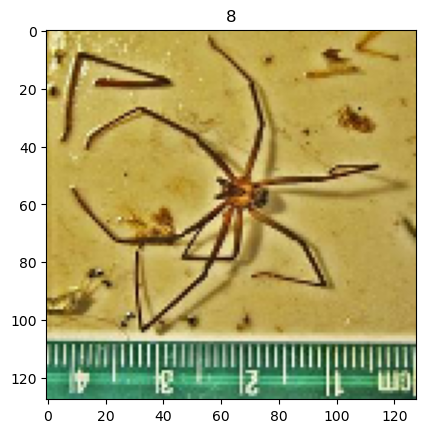

In [9]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nsietetensor/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [13]:
train_generator.class_indices

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [14]:
def schedule(epoch):
    cycle = 0
    if epoch < (EPOCHS // 2):
        cycle = 1 + (epoch * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
    else:
        cycle = 1 + ((EPOCHS - epoch) * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
        factor = MAX_LR - factor

    if ANNEAL_STRATEGY == 'cos':
        lr = factor * (1 + tf.math.cos(tf.constant(np.pi) * (epoch % (EPOCHS // 2)) / (EPOCHS // 2))) / 2
    elif ANNEAL_STRATEGY == 'linear':
        lr = factor * (EPOCHS - epoch) / EPOCHS
    else:
        raise ValueError('Invalid anneal strategy')
    
    wandb.log({'learning_rate': lr})

    return lr

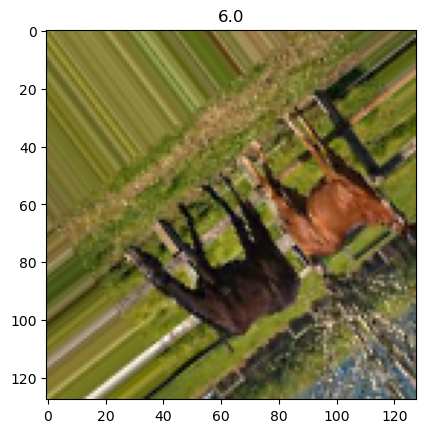

In [15]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [16]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [17]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(128, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(256, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, 3, padding='same', strides=(2,2)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Flatten(),
    layers.Activation('relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
#lr_scheduler = LearningRateScheduler(schedule=schedule, verbose=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0

In [18]:
callbacks = [WandbCallback(), 
             EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True), 
             ModelCheckpoint("model_checkpoint.h5", save_best_only=True),
             #lr_scheduler
             ]

model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks, class_weight=weights)

Epoch 1/50


2023-04-11 00:47:55.159592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.7657 - sparse_categorical_accuracy: 0.2405 - sparse_categorical_crossentropy: 2.0902

2023-04-11 00:49:15.914168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 103s 152ms/step - loss: 1.7657 - sparse_categorical_accuracy: 0.2405 - sparse_categorical_crossentropy: 2.0902 - val_loss: 2.3225 - val_sparse_categorical_accuracy: 0.2381 - val_sparse_categorical_crossentropy: 2.3225
Epoch 2/50
655/655 [==============================] - 111s 170ms/step - loss: 1.5492 - sparse_categorical_accuracy: 0.3423 - sparse_categorical_crossentropy: 1.8249 - val_loss: 1.8911 - val_sparse_categorical_accuracy: 0.3364 - val_sparse_categorical_crossentropy: 1.8911
Epoch 3/50
655/655 [==============================] - 119s 182ms/step - loss: 1.4150 - sparse_categorical_accuracy: 0.4002 - sparse_categorical_crossentropy: 1.6734 - val_loss: 2.1363 - val_sparse_categorical_accuracy: 0.2892 - val_sparse_categorical_crossentropy: 2.1363
Epoch 4/50
655/655 [==============================] - 113s 173ms/step - loss: 1.2981 - sparse_categorical_accuracy: 0.4534 - sparse_categorical_crossentropy: 1.5363 - val_loss: 1.6850 - val_spars

In [19]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy
0,1.765729,0.240464,2.090173,2.322515,0.238150,2.322515
1,1.549173,0.342292,1.824923,1.891148,0.336391,1.891148
2,1.415047,0.400201,1.673368,2.136284,0.289182,2.136284
3,1.298084,0.453382,1.536281,1.685030,0.386850,1.685030
4,1.225162,0.484031,1.451872,2.251267,0.294534,2.251267
5,1.161396,0.509572,1.373284,1.630863,0.435589,1.630863
6,1.103992,0.538836,1.304740,1.723469,0.410359,1.723469
7,1.061772,0.556022,1.258529,1.284265,0.557913,1.284265
8,1.025862,0.572779,1.212930,1.455737,0.515099,1.455737
9,0.997406,0.589392,1.179467,1.848490,0.389335,1.848490


In [20]:
model.evaluate(val_generator)

164/164 [==============================] - 18s 107ms/step - loss: 0.8684 - sparse_categorical_accuracy: 0.7081 - sparse_categorical_crossentropy: 0.8684


[0.868373692035675, 0.7081422209739685, 0.868373692035675]

In [21]:
tf.keras.models.save_model(model, f'model/{name_of_run}.pth')
wandb.save(f'runs/pima_run_{date.today().strftime("%Y-%m-%d")}-{name_of_run}')
wandb.finish()

INFO:tensorflow:Assets written to: model/wider-conv-layers-8-image-generator-penalization-50epoch-stride(2,2).pth/assets


INFO:tensorflow:Assets written to: model/wider-conv-layers-8-image-generator-penalization-50epoch-stride(2,2).pth/assets


loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
sparse_categorical_crossentropy,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅█▅▅▃▄▆▆▃▃▃▇▄▂▂▃▃▂▄▃▃▁▂▂▂▂▂▁▄▁▂▁▄▁▁▂▂
val_sparse_categorical_accuracy,▁▂▂▃▂▄▄▆▅▃▄▆▆▆▃▅▆▆▆▅▇▅▆▆█▇▇▇▇▇█▆█▇▇▆██▇▇
val_sparse_categorical_crossentropy,█▆▇▅█▅▅▃▄▆▆▃▃▃▇▄▂▂▃▃▂▄▃▃▁▂▂▂▂▂▁▄▁▂▁▄▁▁▂▂
loss,0.59358
sparse_categorical_accuracy,0.755
sparse_categorical_crossentropy,0.71568
val_loss,1.01993
val_sparse_categorical_accuracy,0.64048


2023-04-11 02:12:15.812674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


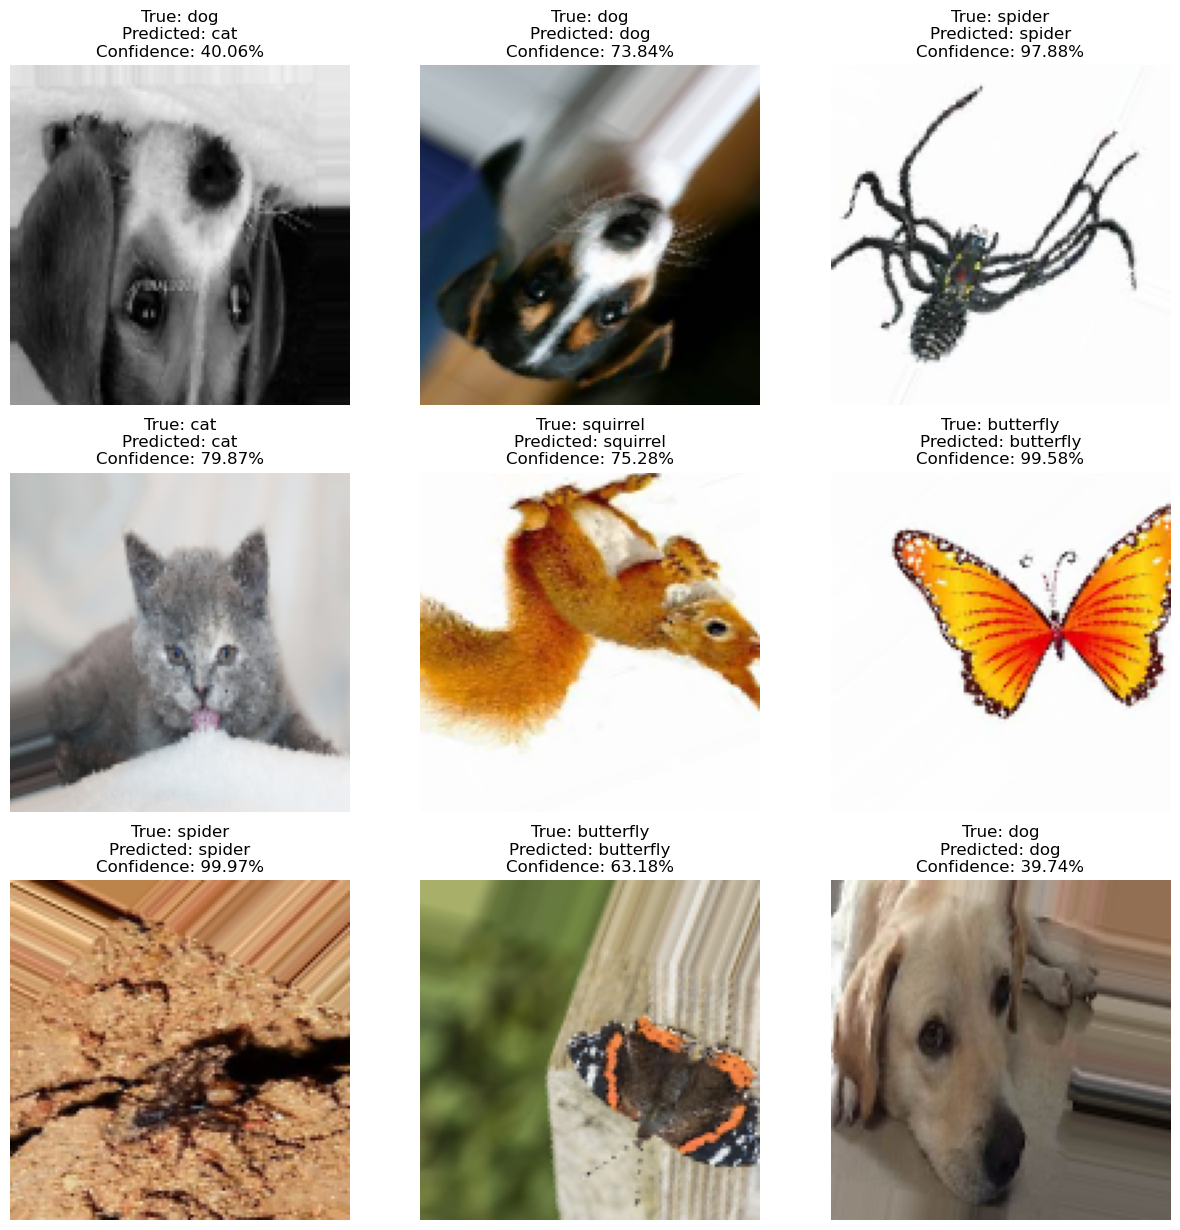

In [22]:
i = 0

plt.figure(figsize=(15, 15))

for image, label in iter(val_generator):
    img_array = tf.keras.utils.img_to_array(image[0])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f'True: {class_names[int(label[0])]}\nPredicted: {class_names[np.argmax(score)]}\nConfidence: {100 * np.max(score):.2f}%')
    plt.axis("off")
    
    i += 1
    if i == 9:
        break